<h1>Estudio de datos meteorológicos para la predicción de precipitaciones.<h1>

Se lee la base de datos del XEMA (Red d'Estacions Meteorològiques Automàtiques de Catalunya). Se trata de un archivo de 30GB, por lo tanto utilizamos pyspark.
<br>Se limpia el archivo y se procesa para obtener un df util para el entrenamiento.
<br>Se seleccionan 5 estaciones meteorológicas con los criterios de diversidad y mayor cantidad de datos.
<br>Se realiza el entrenamiento con regresión (cantidad de precipitación), y con clasificación (lloverá si o no).

<h3>1- Configuración pyspark<h3>

Se ha instalado JAVA, PYTHON I SPARK, i configurar su dirección (path) en variables del sistema HADOOP_HOME, SPARK_HOME y JAVA_HOME

In [1]:
import pandas as pd
import numpy as np
import time
import spark

In [2]:
import findspark
import pyspark
from pyspark.sql import SparkSession

findspark.init()
spark = SparkSession.builder.getOrCreate()

#Se comprueba que pyspark se ha instalado y iniciado correctamente:
df = spark.sql("select 'spark' as hello ")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



<h3>2- Lectura archivos <h3>

Se leen los archivos:
<br>    - Dades meteorològiques de la XEMA.csv (con pyspark)
<br>    - Metadades estacions meteorològiques automàtiques.csv
<br>    - Metadades variables meteorològiques.csv

In [5]:
sdf = spark.read.csv("Dades_meteorol_giques_de_la_XEMA.csv", header=True)
sdf.show()

+--------------+------------+-------------+--------------------+--------------------+-------------+----------+---------+
|            ID|CODI_ESTACIO|CODI_VARIABLE|        DATA_LECTURA|         DATA_EXTREM|VALOR_LECTURA|CODI_ESTAT|CODI_BASE|
+--------------+------------+-------------+--------------------+--------------------+-------------+----------+---------+
|W8442601181600|          W8|           44|26/01/2018 04:00:...|26/01/2018 04:00:...|           87|         V|       SH|
|W8722601181600|          W8|           72|26/01/2018 04:00:...|26/01/2018 04:00:...|            0|         V|       SH|
|W8322601181600|          W8|           32|26/01/2018 04:00:...|                null|          5.6|         V|       SH|
|W8402601181600|          W8|           40|26/01/2018 04:00:...|26/01/2018 04:04:...|          5.6|         V|       SH|
|W8352601181600|          W8|           35|26/01/2018 04:00:...|                null|            0|         V|       SH|
|W8032601181600|          W8|   

In [3]:
dfestacions=pd.read_csv('Metadades_estacions_meteorol_giques_autom_tiques.csv')
dfestacions.head()

,CODI_ESTACIO,NOM_ESTACIO,CODI_TIPUS,LATITUD,LONGITUD,Georeferència,EMPLACAMENT,ALTITUD,CODI_MUNICIPI,NOM_MUNICIPI,CODI_COMARCA,NOM_COMARCA,CODI_PROVINCIA,NOM_PROVINCIA,CODI_XARXA,NOM_XARXA,CODI_ESTAT,NOM_ESTAT,DATA_ALTA,DATA_BAIXA
0,X4,Barcelona - el Raval,A,41.38390,2.16775,POINT (2.16775 41.3839),Facultat de Geografia i Història. c. Montalegr...,33,332,Barcelona,13,Barcelonès,8,Barcelona,1,XEMA,2,Operativa,10/11/2006 12:00:00 AM,NaN
1,YG,Tírvia,A,42.51881,1.24244,POINT (1.24244 42.51881),Heliport de Tírvia,954,634,Tírvia,26,Pallars Sobirà,25,Lleida,1,XEMA,2,Operativa,01/11/2018 12:00:00 AM,NaN
2,DD,Vilassar de Mar,A,41.51175,2.38674,POINT (2.38674 41.51175),"Soc.Civil d'Aigües ""La Mina Vella",44.5,513,Vilassar de Mar,21,Maresme,8,Barcelona,1,XEMA,1,Desmantellada,05/04/1998 12:00:00 AM,01/16/2015 12:00:00 AM
3,VY,Nulles,A,41.25095,1.29863,POINT (1.29863 41.25095),Cooperativa agrària,240,12,Nulles,1,Alt Camp,43,Tarragona,1,XEMA,2,Operativa,09/18/2000 12:00:00 AM,NaN
4,YD,les Borges Blanques,A,41.51135,0.85617,POINT (0.85617 41.51135),Escola Agrària de les Borges Blanques,283,416,Les Borges Blanques,18,Garrigues,25,Lleida,1,XEMA,2,Operativa,01/25/2017 12:00:00 AM,NaN


In [5]:
variables=pd.read_csv('Metadades_variables_meteorol_giques.csv')
variables

,CODI_VARIABLE,NOM_VARIABLE,UNITAT,ACRONIM,CODI_TIPUS_VAR,DECIMALS
0,72,Precipitació màxima en 1 minut,mm,PPTx1min,DAT,1
1,3,Humitat relativa màxima,%,HRx,DAT,0
2,30,Velocitat del vent a 10 m (esc.),m/s,VV10,DAT,1
3,31,Direcció de vent 10 m (m. 1),°,DV10,DAT,0
4,32,Temperatura,°C,T,DAT,1
5,33,Humitat relativa,%,HR,DAT,0
6,34,Pressió atmosfèrica,hPa,P,DAT,1
7,35,Precipitació,mm,PPT,DAT,1
8,36,Irradiància solar global,W/m²,RS,DAT,0
9,38,Gruix de neu a terra,mm,GNEU,DAT,0


<h3>3- Data cleaning <h3>

3.1- Selección de estaciones meteorológicas a estudio

In [6]:
#Si activamos este código veremos cuantas estaciones meteorològicas distintas tienen datos en el archivo de 30GB.
sdf.select("CODI_ESTACIO").distinct().count()

221

In [7]:
#Se eliminan columnas
sdf=sdf.drop('CODI_ESTAT','CODI_BASE')
#Podemos ver cuantos datos tiene cada estación meteorológica:
dades_estacions=sdf.groupby('CODI_ESTACIO').count().orderBy('count').toPandas()
dades_estacions.head(15)

,CODI_ESTACIO,count
0,"U;SH""""",1
1,";42;13/05/2020 9:30:00;13/05/2020 9:57:00;18,5...",1
2,"UH5:00:00;;0,4;V""""",1
3,SH,3
4,None,12
5,U8,8302
6,YP,34736
7,YQ,52798
8,V9,78980
9,YO,176717


In [8]:
dades_est=dades_estacions.drop([0,1,2,4],axis=0)
dades_est.head(15)

,CODI_ESTACIO,count
3,SH,3
5,U8,8302
6,YP,34736
7,YQ,52798
8,V9,78980
9,YO,176717
10,UV,195359
11,KE,219053
12,KX,220160
13,MW,227812


In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

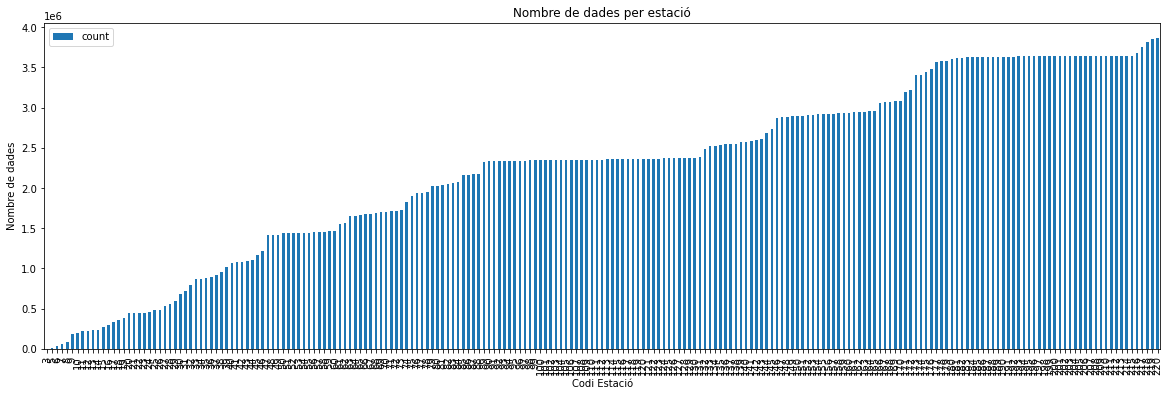

In [10]:
#Se visualiza gráficamente cuántas observaciones tiene cada estacion meteorológica.
dades_est.plot(kind='bar', figsize=(20,6))
plt.title('Nombre de dades per estació')
plt.xlabel('Codi Estació')
plt.ylabel('Nombre de dades')
plt.show()

In [11]:
dades_est.sort_values('count',ascending=False,inplace=True)
dades_est.head()

,CODI_ESTACIO,count
220,DP,3866059
219,DG,3857694
218,VQ,3812185
217,VS,3759456
216,CG,3677158


In [12]:
#Se obtiene una tabla de las estaciones meteorológicas con el número de observaciones y sus coordenadas, para obtener una visualización en mapa.
dades_est1=pd.merge(left=dades_est, right=dfestacions, how='left', left_on='CODI_ESTACIO', right_on='CODI_ESTACIO')
dades_est1=dades_est1[['CODI_ESTACIO','NOM_ESTACIO','count','LATITUD','LONGITUD','ALTITUD']]
dades_est1=dades_est1.dropna()
dades_est1.head(40)

,CODI_ESTACIO,NOM_ESTACIO,count,LATITUD,LONGITUD,ALTITUD
0,DP,Das - Aeròdrom,3866059,42.38605,1.86640,"1,097"
1,DG,Núria (1.971 m),3857694,42.39848,2.15517,"1,971.4"
2,VQ,Constantí,3812185,41.17130,1.16774,112
3,VS,Lac Redon (2.247 m),3759456,42.63835,0.77889,"2,247"
4,CG,Molló - Fabert,3677158,42.37717,2.41456,"1,405"
5,C6,Castellnou de Seana,3641157,41.65660,0.95172,264
6,CC,Orís,3640388,42.07398,2.20862,626
7,CJ,Organyà,3640259,42.21624,1.33132,566.5
8,C7,Tàrrega,3640035,41.66695,1.16234,427
9,CY,Muntanyola,3639460,41.87813,2.17873,816


In [13]:
#veiem en quina posició es troba l'estació meteorològica de Tremp:

In [14]:
# Vemos en qué posición se encuentra la estación meteorológica de Tremp, nuestro pueblo.
dades_est1[dades_est1['NOM_ESTACIO']=='Tremp'].index.tolist()

[154]

In [15]:
dades_est1.loc[154]

CODI_ESTACIO          XQ
NOM_ESTACIO        Tremp
count            1676369
LATITUD         42.16252
LONGITUD         0.88814
ALTITUD              473
Name: 154, dtype: object

In [16]:
# Mapeamos les estaciones:
import folium

world_map=folium.Map(location=[41.7,1.5],zoom_start=8)
for lat,lng,label in zip(dades_est1.LATITUD,dades_est1.LONGITUD,dades_est1.NOM_ESTACIO):
    folium.features.CircleMarker(
        [lat,lng],
        radius=5,
        color='yellow',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6).add_to(world_map)
world_map

In [17]:
# Mapeamos les 25 estaciones con más observaciones:
world_map=folium.Map(location=[41.7,1.5],zoom_start=8)
for lat,lng,label in zip(dades_est1[0:25].LATITUD,dades_est1[0:25].LONGITUD,dades_est1[0:25].NOM_ESTACIO):
    folium.features.CircleMarker(
        [lat,lng],
        radius=5,
        color='yellow',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6).add_to(world_map)
world_map

In [18]:
# De las primeras 25 estaciones con mayor número de observaciones, escogemos 6 puntos con localización diversa:
# Banyoles, Barcelona - Observatori Fabra, Constantí, Castellnou de Seana, Das, Sant Romà d'Abella
est=dades_est1.loc[dades_est1['NOM_ESTACIO'].isin(["Das - Aeròdrom","Constantí","Castellnou de Seana","Sant Romà d'Abella","Banyoles","Barcelona - Observatori Fabra"])]
est

,CODI_ESTACIO,NOM_ESTACIO,count,LATITUD,LONGITUD,ALTITUD
0,DP,Das - Aeròdrom,3866059,42.38605,1.86640,"1,097"
2,VQ,Constantí,3812185,41.17130,1.16774,112
5,C6,Castellnou de Seana,3641157,41.65660,0.95172,264
18,CP,Sant Romà d'Abella,3638402,42.13924,1.03893,690
22,DJ,Banyoles,3637427,42.11653,2.78969,176
23,D5,Barcelona - Observatori Fabra,3637415,41.41843,2.12388,411.2


3.2- Filtrado de datos de la estación seleccionada

In [19]:
#Creamos diccionario con la tabla de variables:
variables['CODI_VARIABLE']=variables['CODI_VARIABLE'].astype(str)
var_dict=variables[['CODI_VARIABLE','NOM_VARIABLE']]
var_dict=var_dict.set_index('CODI_VARIABLE').T.to_dict('records')
var_dict=var_dict[0]
var_dict

{'72': 'Precipitació màxima en 1 minut',
 '3': 'Humitat relativa màxima',
 '30': 'Velocitat del vent a 10 m (esc.)',
 '31': 'Direcció de vent 10 m (m. 1)',
 '32': 'Temperatura',
 '33': 'Humitat relativa',
 '34': 'Pressió atmosfèrica',
 '35': 'Precipitació',
 '36': 'Irradiància solar global',
 '38': 'Gruix de neu a terra',
 '40': 'Temperatura màxima',
 '42': 'Temperatura mínima',
 '44': 'Humitat relativa mínima',
 '46': 'Velocitat del vent a 2 m (esc.)',
 '47': 'Direcció del vent a 2 m (m. 1)',
 '48': 'Velocitat del vent a 6 m (esc.)',
 '49': 'Direcció del vent a 6 m (m. 1)',
 '50': 'Ratxa màxima del vent a 10 m',
 '51': 'Direcció de la ratxa màxima del vent a 10 m',
 '53': 'Ratxa màxima del vent a 6 m',
 '54': 'Direcció de la ratxa màxima del vent a 6 m',
 '56': 'Ratxa màxima del vent a 2 m',
 '57': 'Direcció de la ratxa màxima del vent a 2 m',
 '59': 'Irradiància neta',
 '1': 'Pressió atmosfèrica màxima',
 '2': 'Pressió atmosfèrica mínima'}

In [20]:
# Filtramos df pyspark con el código de la estación seleccionada
df_a=sdf[sdf['CODI_ESTACIO']==est.loc[0,'CODI_ESTACIO']].toPandas()
df_a.head()

,ID,CODI_ESTACIO,CODI_VARIABLE,DATA_LECTURA,DATA_EXTREM,VALOR_LECTURA
0,DP012601181630,DP,1,26/01/2018 04:30:00 PM,26/01/2018 04:58:00 PM,892
1,DP342601181630,DP,34,26/01/2018 04:30:00 PM,None,891.7
2,DP382601181630,DP,38,26/01/2018 04:30:00 PM,None,82
3,DP322601181630,DP,32,26/01/2018 04:30:00 PM,None,1.4
4,DP402601181630,DP,40,26/01/2018 04:30:00 PM,26/01/2018 04:55:00 PM,1.9


In [21]:
# Pivotamos la tabla para obtener una columna de cada variable, quedando una fila para cada fecha y hora de observación. Eliminamos filas duplicadas (algunas fechas lo están).
df_b=df_a.pivot_table(index='DATA_LECTURA',columns='CODI_VARIABLE',values='VALOR_LECTURA')
df_b = pd.DataFrame(df_b.to_records())
df_b.columns.astype(str)
df_b.drop_duplicates(subset ="DATA_LECTURA",keep = 'first', inplace = True)
df_b.head()

,DATA_LECTURA,1,2,3,30,31,32,33,34,35,36,38,40,42,44,50,51,72
0,01/01/2009 01:00:00 AM,NaN,NaN,NaN,NaN,NaN,-0.2,100.0,896.0,0.0,0.0,0.0,0.1,-0.4,100.0,2.2,136.0,NaN
1,01/01/2009 01:00:00 PM,NaN,NaN,NaN,NaN,NaN,8.7,58.0,892.0,0.0,298.0,0.0,8.8,8.4,56.0,1.3,163.0,NaN
2,01/01/2009 01:30:00 AM,NaN,NaN,NaN,NaN,NaN,0.1,100.0,895.0,0.0,0.0,0.0,0.2,-0.2,100.0,0.9,282.0,NaN
3,01/01/2009 01:30:00 PM,NaN,NaN,NaN,NaN,NaN,9.0,55.0,892.0,0.0,247.0,0.0,9.4,8.8,54.0,1.4,210.0,NaN
4,01/01/2009 02:00:00 AM,NaN,NaN,NaN,NaN,NaN,-0.5,100.0,895.0,0.0,0.0,0.0,-0.1,-0.8,100.0,1.6,323.0,NaN


In [22]:
# Se renombran las columnas con el nombre del código de variable
df_c=df_b.rename(columns=var_dict)
df_c.head()

,DATA_LECTURA,Pressió atmosfèrica màxima,Pressió atmosfèrica mínima,Humitat relativa màxima,Velocitat del vent a 10 m (esc.),Direcció de vent 10 m (m. 1),Temperatura,Humitat relativa,Pressió atmosfèrica,Precipitació,Irradiància solar global,Gruix de neu a terra,Temperatura màxima,Temperatura mínima,Humitat relativa mínima,Ratxa màxima del vent a 10 m,Direcció de la ratxa màxima del vent a 10 m,Precipitació màxima en 1 minut
0,01/01/2009 01:00:00 AM,NaN,NaN,NaN,NaN,NaN,-0.2,100.0,896.0,0.0,0.0,0.0,0.1,-0.4,100.0,2.2,136.0,NaN
1,01/01/2009 01:00:00 PM,NaN,NaN,NaN,NaN,NaN,8.7,58.0,892.0,0.0,298.0,0.0,8.8,8.4,56.0,1.3,163.0,NaN
2,01/01/2009 01:30:00 AM,NaN,NaN,NaN,NaN,NaN,0.1,100.0,895.0,0.0,0.0,0.0,0.2,-0.2,100.0,0.9,282.0,NaN
3,01/01/2009 01:30:00 PM,NaN,NaN,NaN,NaN,NaN,9.0,55.0,892.0,0.0,247.0,0.0,9.4,8.8,54.0,1.4,210.0,NaN
4,01/01/2009 02:00:00 AM,NaN,NaN,NaN,NaN,NaN,-0.5,100.0,895.0,0.0,0.0,0.0,-0.1,-0.8,100.0,1.6,323.0,NaN


In [23]:
# Se separa la columna de DATA_LECTURA en DATA i HORA:
df_d=df_c
df_d['HORA']=df_c['DATA_LECTURA'].str[12:22]
df_d['DATA_LECTURA']=df_c['DATA_LECTURA'].str[:10]
df_d.head()

,DATA_LECTURA,Pressió atmosfèrica màxima,Pressió atmosfèrica mínima,Humitat relativa màxima,Velocitat del vent a 10 m (esc.),Direcció de vent 10 m (m. 1),Temperatura,Humitat relativa,Pressió atmosfèrica,Precipitació,Irradiància solar global,Gruix de neu a terra,Temperatura màxima,Temperatura mínima,Humitat relativa mínima,Ratxa màxima del vent a 10 m,Direcció de la ratxa màxima del vent a 10 m,Precipitació màxima en 1 minut,HORA
0,01/01/2009,NaN,NaN,NaN,NaN,NaN,-0.2,100.0,896.0,0.0,0.0,0.0,0.1,-0.4,100.0,2.2,136.0,NaN,1:00:00 AM
1,01/01/2009,NaN,NaN,NaN,NaN,NaN,8.7,58.0,892.0,0.0,298.0,0.0,8.8,8.4,56.0,1.3,163.0,NaN,1:00:00 PM
2,01/01/2009,NaN,NaN,NaN,NaN,NaN,0.1,100.0,895.0,0.0,0.0,0.0,0.2,-0.2,100.0,0.9,282.0,NaN,1:30:00 AM
3,01/01/2009,NaN,NaN,NaN,NaN,NaN,9.0,55.0,892.0,0.0,247.0,0.0,9.4,8.8,54.0,1.4,210.0,NaN,1:30:00 PM
4,01/01/2009,NaN,NaN,NaN,NaN,NaN,-0.5,100.0,895.0,0.0,0.0,0.0,-0.1,-0.8,100.0,1.6,323.0,NaN,2:00:00 AM


In [24]:
# Se cuenta el número de observaciones por hora. Se comprobarán los duplicados:
df_d.groupby('HORA').count()

,DATA_LECTURA,Pressió atmosfèrica màxima,Pressió atmosfèrica mínima,Humitat relativa màxima,Velocitat del vent a 10 m (esc.),Direcció de vent 10 m (m. 1),Temperatura,Humitat relativa,Pressió atmosfèrica,Precipitació,Irradiància solar global,Gruix de neu a terra,Temperatura màxima,Temperatura mínima,Humitat relativa mínima,Ratxa màxima del vent a 10 m,Direcció de la ratxa màxima del vent a 10 m,Precipitació màxima en 1 minut
HORA,,,,,,,,,,,,,,,,,,
0:00:00 AM,4790,4654,4654,4653,4651,4651,4787,4787,4790,4790,4789,4782,4787,4787,4787,4785,4785,4655
0:00:00 PM,4787,4660,4652,4651,4649,4649,4785,4785,4787,4787,4786,4776,4785,4785,4785,4782,4782,4651
0:30:00 AM,4790,4656,4654,4653,4649,4649,4787,4787,4790,4790,4789,4786,4787,4787,4787,4781,4781,4655
0:30:00 PM,4787,4659,4652,4651,4646,4646,4785,4785,4787,4787,4786,4778,4785,4785,4785,4779,4779,4651
1:00:00 AM,9578,9306,9305,9303,9295,9292,9573,9573,9578,9578,9577,9559,9572,9573,9572,9560,9558,9306
1:00:00 PM,9576,9309,9311,9303,9297,9297,9571,9571,9576,9576,9574,9553,9571,9571,9571,9561,9561,9305
1:30:00 AM,9577,9303,9304,9303,9296,9292,9572,9572,9577,9577,9576,9550,9572,9572,9572,9561,9559,9305
1:30:00 PM,9575,9330,9317,9302,9299,9299,9570,9570,9575,9575,9573,9549,9570,9570,9570,9566,9566,9304
2:00:00 AM,9576,9342,9313,9302,9294,9289,9572,9572,9576,9576,9576,9555,9571,9572,9572,9559,9556,9302


In [25]:
#Se seleccionan las observaciones de las 00 AM:
df_0am=df_d[df_d['HORA']=='0:00:00 AM'].reset_index()
df_0am=df_0am.drop('index',axis=1)
df_0am.head()

,DATA_LECTURA,Pressió atmosfèrica màxima,Pressió atmosfèrica mínima,Humitat relativa màxima,Velocitat del vent a 10 m (esc.),Direcció de vent 10 m (m. 1),Temperatura,Humitat relativa,Pressió atmosfèrica,Precipitació,Irradiància solar global,Gruix de neu a terra,Temperatura màxima,Temperatura mínima,Humitat relativa mínima,Ratxa màxima del vent a 10 m,Direcció de la ratxa màxima del vent a 10 m,Precipitació màxima en 1 minut,HORA
0,01/01/2009,NaN,NaN,NaN,NaN,NaN,0.8,100.0,895.0,0.0,316.0,0.0,1.6,-0.1,100.0,1.2,85.0,NaN,0:00:00 AM
1,01/01/2010,875.0,875.0,74.0,2.9,193.0,2.3,72.0,875.0,0.0,325.0,0.0,2.9,1.9,70.0,5.3,192.0,0.0,0:00:00 AM
2,01/01/2011,893.5,893.1,88.0,1.0,351.0,1.5,84.0,893.4,0.0,282.0,0.0,2.2,1.2,80.0,2.0,352.0,0.0,0:00:00 AM
3,01/01/2012,900.8,900.2,100.0,0.9,70.0,0.5,100.0,900.6,0.0,227.0,0.0,0.8,0.1,100.0,1.9,86.0,0.0,0:00:00 AM
4,01/01/2013,891.5,891.3,98.0,1.2,60.0,-1.6,98.0,891.4,0.1,73.0,20.0,-1.4,-1.9,98.0,2.4,52.0,0.1,0:00:00 AM


3.3- Sintetización tabla diaria

Para obtener una table genérica, se totalizan los valores máximos, mínimos, medios y sumatorios en función de cada variable. Se obtendrá una tabla de resumen diario:

In [26]:
#Selección variables de máximos:
df_dmax=df_d.groupby('DATA_LECTURA')['Pressió atmosfèrica màxima','Humitat relativa màxima','Temperatura màxima','Ratxa màxima del vent a 10 m','Precipitació màxima en 1 minut'].max().reset_index()
df_dmax.head()

C:\Users\anna\AppData\Local\Temp\ipykernel_14896\3366192664.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dmax=df_d.groupby('DATA_LECTURA')['Pressió atmosfèrica màxima','Humitat relativa màxima','Temperatura màxima','Ratxa màxima del vent a 10 m','Precipitació màxima en 1 minut'].max().reset_index()


,DATA_LECTURA,Pressió atmosfèrica màxima,Humitat relativa màxima,Temperatura màxima,Ratxa màxima del vent a 10 m,Precipitació màxima en 1 minut
0,01/01/2009,896.0,NaN,9.7,4.4,NaN
1,01/01/2010,886.0,99.0,6.2,11.6,0.1
2,01/01/2011,893.6,99.0,9.2,3.9,0.0
3,01/01/2012,901.1,100.0,12.6,4.3,0.0
4,01/01/2013,893.6,99.0,3.4,3.9,0.1


In [27]:
#Selección variables de mínimos:
df_dmin=df_d.groupby('DATA_LECTURA')['Pressió atmosfèrica mínima','Humitat relativa mínima','Temperatura mínima'].min().reset_index()
df_dmin.head()

C:\Users\anna\AppData\Local\Temp\ipykernel_14896\1614344858.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dmin=df_d.groupby('DATA_LECTURA')['Pressió atmosfèrica mínima','Humitat relativa mínima','Temperatura mínima'].min().reset_index()


,DATA_LECTURA,Pressió atmosfèrica mínima,Humitat relativa mínima,Temperatura mínima
0,01/01/2009,892.0,54.0,-2.7
1,01/01/2010,869.0,59.0,-3.4
2,01/01/2011,889.9,46.0,-4.6
3,01/01/2012,895.4,55.0,-2.4
4,01/01/2013,888.6,77.0,-4.9


In [28]:
#Selección variables de media:
df_dmitja=df_d.groupby('DATA_LECTURA')['Temperatura','Humitat relativa','Pressió atmosfèrica','Irradiància solar global','Gruix de neu a terra','Velocitat del vent a 10 m (esc.)','Direcció de vent 10 m (m. 1)','Direcció de la ratxa màxima del vent a 10 m'].mean().reset_index()
df_dmitja.head()

C:\Users\anna\AppData\Local\Temp\ipykernel_14896\3352336472.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dmitja=df_d.groupby('DATA_LECTURA')['Temperatura','Humitat relativa','Pressió atmosfèrica','Irradiància solar global','Gruix de neu a terra','Velocitat del vent a 10 m (esc.)','Direcció de vent 10 m (m. 1)','Direcció de la ratxa màxima del vent a 10 m'].mean().reset_index()


,DATA_LECTURA,Temperatura,Humitat relativa,Pressió atmosfèrica,Irradiància solar global,Gruix de neu a terra,Velocitat del vent a 10 m (esc.),Direcció de vent 10 m (m. 1),Direcció de la ratxa màxima del vent a 10 m
0,01/01/2009,2.150000,89.020833,893.875000,83.666667,0.0000,NaN,NaN,198.583333
1,01/01/2010,1.456250,79.791667,876.208333,93.437500,0.0000,3.183333,204.750000,220.166667
2,01/01/2011,0.637500,83.666667,891.877083,91.479167,0.0000,0.939583,189.854167,196.541667
3,01/01/2012,2.727083,91.770833,898.129167,79.520833,0.0000,1.247917,153.791667,171.770833
4,01/01/2013,-1.354167,92.979167,890.922917,42.708333,9.0625,1.262500,162.833333,158.333333


In [29]:
#Selección variables de sumatorio:
df_dsum=df_d.groupby('DATA_LECTURA')['Precipitació'].sum().reset_index()
df_dsum.head()

,DATA_LECTURA,Precipitació
0,01/01/2009,0.0
1,01/01/2010,0.8
2,01/01/2011,0.0
3,01/01/2012,0.0
4,01/01/2013,2.3


In [30]:
#Agrupación de todas las variables en tabla:
df_T=df_0am['DATA_LECTURA']
df_T=pd.merge(left=df_T, right=df_dmax, how='left', left_on='DATA_LECTURA', right_on='DATA_LECTURA')
df_T=pd.merge(left=df_T, right=df_dmin, how='left', left_on='DATA_LECTURA', right_on='DATA_LECTURA')
df_T=pd.merge(left=df_T, right=df_dmitja, how='left', left_on='DATA_LECTURA', right_on='DATA_LECTURA')
df_T=pd.merge(left=df_T, right=df_dsum, how='left', left_on='DATA_LECTURA', right_on='DATA_LECTURA')
df_T=df_T.sort_values('DATA_LECTURA')
df_T.head()

,DATA_LECTURA,Pressió atmosfèrica màxima,Humitat relativa màxima,Temperatura màxima,Ratxa màxima del vent a 10 m,Precipitació màxima en 1 minut,Pressió atmosfèrica mínima,Humitat relativa mínima,Temperatura mínima,Temperatura,Humitat relativa,Pressió atmosfèrica,Irradiància solar global,Gruix de neu a terra,Velocitat del vent a 10 m (esc.),Direcció de vent 10 m (m. 1),Direcció de la ratxa màxima del vent a 10 m,Precipitació
0,01/01/2009,896.0,NaN,9.7,4.4,NaN,892.0,54.0,-2.7,2.150000,89.020833,893.875000,83.666667,0.0000,NaN,NaN,198.583333,0.0
1,01/01/2010,886.0,99.0,6.2,11.6,0.1,869.0,59.0,-3.4,1.456250,79.791667,876.208333,93.437500,0.0000,3.183333,204.750000,220.166667,0.8
2,01/01/2011,893.6,99.0,9.2,3.9,0.0,889.9,46.0,-4.6,0.637500,83.666667,891.877083,91.479167,0.0000,0.939583,189.854167,196.541667,0.0
3,01/01/2012,901.1,100.0,12.6,4.3,0.0,895.4,55.0,-2.4,2.727083,91.770833,898.129167,79.520833,0.0000,1.247917,153.791667,171.770833,0.0
4,01/01/2013,893.6,99.0,3.4,3.9,0.1,888.6,77.0,-4.9,-1.354167,92.979167,890.922917,42.708333,9.0625,1.262500,162.833333,158.333333,2.3


In [31]:
#Corrección formato fecha y orden por fecha:
df_T['DATA_LECTURA']=pd.to_datetime(df_T['DATA_LECTURA'],format="%d/%m/%Y")
df_T.sort_values('DATA_LECTURA',inplace=True)
df_T=df_T.reset_index().drop('index',axis=1)
df_T.head()

,DATA_LECTURA,Pressió atmosfèrica màxima,Humitat relativa màxima,Temperatura màxima,Ratxa màxima del vent a 10 m,Precipitació màxima en 1 minut,Pressió atmosfèrica mínima,Humitat relativa mínima,Temperatura mínima,Temperatura,Humitat relativa,Pressió atmosfèrica,Irradiància solar global,Gruix de neu a terra,Velocitat del vent a 10 m (esc.),Direcció de vent 10 m (m. 1),Direcció de la ratxa màxima del vent a 10 m,Precipitació
0,2009-01-01,896.0,NaN,9.7,4.4,NaN,892.0,54.0,-2.7,2.150000,89.020833,893.875000,83.666667,0.0,NaN,NaN,198.583333,0.0
1,2009-01-02,893.0,NaN,6.8,3.8,NaN,890.0,71.0,-3.4,1.683333,92.520833,891.270833,54.437500,0.0,NaN,NaN,168.166667,0.0
2,2009-01-03,891.0,NaN,7.5,3.3,NaN,887.0,22.0,-7.6,-1.666667,80.041667,889.375000,113.770833,0.0,NaN,NaN,153.395833,0.0
3,2009-01-04,892.0,NaN,8.9,9.2,NaN,889.0,13.0,-11.2,-2.347917,64.854167,890.729167,111.687500,0.0,NaN,NaN,148.395833,0.0
4,2009-01-05,891.0,NaN,7.4,3.2,NaN,884.0,12.0,-10.7,-2.991667,62.479167,887.395833,129.208333,0.0,NaN,NaN,159.166667,0.0


In [32]:
# Añadimos columna Precipitació demà
df_T['Precipitació demà']=0
for i in range(0,len(df_T['DATA_LECTURA'])-1):
    df_T.loc[i,'Precipitació demà']=df_T.loc[i+1,'Precipitació']
df_T.head(20)

,DATA_LECTURA,Pressió atmosfèrica màxima,Humitat relativa màxima,Temperatura màxima,Ratxa màxima del vent a 10 m,Precipitació màxima en 1 minut,Pressió atmosfèrica mínima,Humitat relativa mínima,Temperatura mínima,Temperatura,Humitat relativa,Pressió atmosfèrica,Irradiància solar global,Gruix de neu a terra,Velocitat del vent a 10 m (esc.),Direcció de vent 10 m (m. 1),Direcció de la ratxa màxima del vent a 10 m,Precipitació,Precipitació demà
0,2009-01-01,896.0,NaN,9.7,4.4,NaN,892.0,54.0,-2.7,2.150000,89.020833,893.875000,83.666667,0.000000,NaN,NaN,198.583333,0.0,0.0
1,2009-01-02,893.0,NaN,6.8,3.8,NaN,890.0,71.0,-3.4,1.683333,92.520833,891.270833,54.437500,0.000000,NaN,NaN,168.166667,0.0,0.0
2,2009-01-03,891.0,NaN,7.5,3.3,NaN,887.0,22.0,-7.6,-1.666667,80.041667,889.375000,113.770833,0.000000,NaN,NaN,153.395833,0.0,0.0
3,2009-01-04,892.0,NaN,8.9,9.2,NaN,889.0,13.0,-11.2,-2.347917,64.854167,890.729167,111.687500,0.000000,NaN,NaN,148.395833,0.0,0.0
4,2009-01-05,891.0,NaN,7.4,3.2,NaN,884.0,12.0,-10.7,-2.991667,62.479167,887.395833,129.208333,0.000000,NaN,NaN,159.166667,0.0,8.0
5,2009-01-06,885.0,NaN,-2.4,9.8,NaN,881.0,67.0,-8.2,-4.943750,86.541667,883.291667,17.916667,32.479167,NaN,NaN,147.312500,8.0,0.0
6,2009-01-07,887.0,NaN,-0.9,9.4,NaN,883.0,37.0,-15.4,-8.364583,72.250000,884.250000,127.937500,43.166667,NaN,NaN,150.395833,0.0,0.0
7,2009-01-08,893.0,NaN,-1.2,3.2,NaN,886.0,50.0,-16.0,-8.029167,75.166667,889.479167,112.125000,32.854167,NaN,NaN,147.812500,0.0,0.1
8,2009-01-09,893.0,NaN,0.9,4.3,NaN,890.0,66.0,-7.3,-3.418750,88.333333,892.104167,47.833333,31.354167,NaN,NaN,161.583333,0.1,3.7
9,2009-01-10,901.0,NaN,2.6,3.4,NaN,892.0,84.0,-6.5,-2.158333,97.229167,895.312500,50.041667,48.020833,NaN,NaN,171.062500,3.7,0.1


In [33]:
# Renombramos columnas:
df_T=df_T.rename(columns={'DATA_LECTURA':'DATA','Pressió atmosfèrica màxima':'Pressió atm. max','Humitat relativa màxima':'Humitat rel.max','Temperatura màxima':'Temp max','Ratxa màxima del vent a 10 m':'Ratxa max vent (10m)','Precipitació màxima en 1 minut':'Precipitació max 1min','Pressió atmosfèrica mínima':'Pressió atm. min','Humitat relativa mínima':'Humitat rel. min','Temperatura mínima':'Temp min','Temperatura':'Temp mitja','Humitat relativa':'Humitat rel mitja','Pressió atmosfèrica':'Pressió atm mitja','Irradiància solar global':'Irradiància solar mitja','Gruix de neu a terra':'Gruix neu mitja', 'Velocitat del vent a 10 m (esc.)':'Velocitat vent (10m) mitja','Direcció de vent 10 m (m. 1)':'Direcció vent mitja', 'Direcció de la ratxa màxima del vent a 10 m':'Direcció vent max mitja', 'Precipitació': 'Precipitació tot'})
df_T['Dif.Temp']=df_T['Temp max']-df_T['Temp min']
df_T['Dif.Pressió']=df_T['Pressió atm. max']-df_T['Pressió atm. min']
df_T['Dif.Hum']=df_T['Humitat rel.max']-df_T['Humitat rel. min']
df_T.head()

,DATA,Pressió atm. max,Humitat rel.max,Temp max,Ratxa max vent (10m),Precipitació max 1min,Pressió atm. min,Humitat rel. min,Temp min,Temp mitja,...,Irradiància solar mitja,Gruix neu mitja,Velocitat vent (10m) mitja,Direcció vent mitja,Direcció vent max mitja,Precipitació tot,Precipitació demà,Dif.Temp,Dif.Pressió,Dif.Hum
0,2009-01-01,896.0,NaN,9.7,4.4,NaN,892.0,54.0,-2.7,2.150000,...,83.666667,0.0,NaN,NaN,198.583333,0.0,0.0,12.4,4.0,NaN
1,2009-01-02,893.0,NaN,6.8,3.8,NaN,890.0,71.0,-3.4,1.683333,...,54.437500,0.0,NaN,NaN,168.166667,0.0,0.0,10.2,3.0,NaN
2,2009-01-03,891.0,NaN,7.5,3.3,NaN,887.0,22.0,-7.6,-1.666667,...,113.770833,0.0,NaN,NaN,153.395833,0.0,0.0,15.1,4.0,NaN
3,2009-01-04,892.0,NaN,8.9,9.2,NaN,889.0,13.0,-11.2,-2.347917,...,111.687500,0.0,NaN,NaN,148.395833,0.0,0.0,20.1,3.0,NaN
4,2009-01-05,891.0,NaN,7.4,3.2,NaN,884.0,12.0,-10.7,-2.991667,...,129.208333,0.0,NaN,NaN,159.166667,0.0,8.0,18.1,7.0,NaN


In [34]:
# Reordenamos columnas:
dfT=0
dfT=df_T[['DATA','Temp mitja','Temp max','Temp min','Dif.Temp','Pressió atm mitja','Pressió atm. max','Pressió atm. min','Dif.Pressió','Humitat rel mitja','Humitat rel.max','Humitat rel. min','Dif.Hum','Irradiància solar mitja','Gruix neu mitja','Velocitat vent (10m) mitja','Direcció vent mitja','Ratxa max vent (10m)','Direcció vent max mitja','Precipitació tot','Precipitació max 1min','Precipitació demà']]
dfT=dfT.round(1)
dfT.head()

,DATA,Temp mitja,Temp max,Temp min,Dif.Temp,Pressió atm mitja,Pressió atm. max,Pressió atm. min,Dif.Pressió,Humitat rel mitja,...,Dif.Hum,Irradiància solar mitja,Gruix neu mitja,Velocitat vent (10m) mitja,Direcció vent mitja,Ratxa max vent (10m),Direcció vent max mitja,Precipitació tot,Precipitació max 1min,Precipitació demà
0,2009-01-01,2.2,9.7,-2.7,12.4,893.9,896.0,892.0,4.0,89.0,...,NaN,83.7,0.0,NaN,NaN,4.4,198.6,0.0,NaN,0.0
1,2009-01-02,1.7,6.8,-3.4,10.2,891.3,893.0,890.0,3.0,92.5,...,NaN,54.4,0.0,NaN,NaN,3.8,168.2,0.0,NaN,0.0
2,2009-01-03,-1.7,7.5,-7.6,15.1,889.4,891.0,887.0,4.0,80.0,...,NaN,113.8,0.0,NaN,NaN,3.3,153.4,0.0,NaN,0.0
3,2009-01-04,-2.3,8.9,-11.2,20.1,890.7,892.0,889.0,3.0,64.9,...,NaN,111.7,0.0,NaN,NaN,9.2,148.4,0.0,NaN,0.0
4,2009-01-05,-3.0,7.4,-10.7,18.1,887.4,891.0,884.0,7.0,62.5,...,NaN,129.2,0.0,NaN,NaN,3.2,159.2,0.0,NaN,8.0


In [35]:
dfT['Humitat rel mitja']=dfT['Humitat rel mitja'].fillna(df_T['Humitat rel mitja'].mean())
dfT['Temp mitja']=dfT['Temp mitja'].fillna(df_T['Temp mitja'].mean())
dfT['Humitat rel. min']=dfT['Humitat rel. min'].fillna(df_T['Humitat rel. min'].mean())
dfT['Ratxa max vent (10m)']=dfT['Ratxa max vent (10m)'].fillna(df_T['Ratxa max vent (10m)'].mean())
dfT['Direcció vent max mitja']=dfT['Direcció vent max mitja'].fillna(df_T['Direcció vent max mitja'].mean())
dfT['Humitat rel.max']=dfT['Humitat rel.max'].fillna(df_T['Humitat rel.max'].mean())
dfT['Dif.Hum']=dfT['Dif.Hum'].fillna(df_T['Dif.Hum'].mean())
dfT['Velocitat vent (10m) mitja']=dfT['Velocitat vent (10m) mitja'].fillna(df_T['Velocitat vent (10m) mitja'].mean())
dfT['Direcció vent mitja']=dfT['Direcció vent mitja'].fillna(df_T['Direcció vent mitja'].mean())
dfT['Precipitació max 1min']=dfT['Precipitació max 1min'].fillna(df_T['Precipitació max 1min'].mean())
dfT.dtypes

DATA                          datetime64[ns]
Temp mitja                           float64
Temp max                             float64
Temp min                             float64
Dif.Temp                             float64
Pressió atm mitja                    float64
Pressió atm. max                     float64
Pressió atm. min                     float64
Dif.Pressió                          float64
Humitat rel mitja                    float64
Humitat rel.max                      float64
Humitat rel. min                     float64
Dif.Hum                              float64
Irradiància solar mitja              float64
Gruix neu mitja                      float64
Velocitat vent (10m) mitja           float64
Direcció vent mitja                  float64
Ratxa max vent (10m)                 float64
Direcció vent max mitja              float64
Precipitació tot                     float64
Precipitació max 1min                float64
Precipitació demà                    float64
dtype: obj

In [36]:
dfT.isnull().sum()

DATA                          0
Temp mitja                    0
Temp max                      0
Temp min                      0
Dif.Temp                      0
Pressió atm mitja             0
Pressió atm. max              0
Pressió atm. min              0
Dif.Pressió                   0
Humitat rel mitja             0
Humitat rel.max               0
Humitat rel. min              0
Dif.Hum                       0
Irradiància solar mitja       0
Gruix neu mitja               0
Velocitat vent (10m) mitja    0
Direcció vent mitja           0
Ratxa max vent (10m)          0
Direcció vent max mitja       0
Precipitació tot              0
Precipitació max 1min         0
Precipitació demà             0
dtype: int64

In [39]:
dfC=dfT
dfC['Precipitació (bool)']=dfC['Precipitació tot'].astype(bool)
dfC['Precipitació demà(bool)']=dfC['Precipitació demà'].astype(bool)
dfC.head()

,DATA,Temp mitja,Temp max,Temp min,Dif.Temp,Pressió atm mitja,Pressió atm. max,Pressió atm. min,Dif.Pressió,Humitat rel mitja,...,Gruix neu mitja,Velocitat vent (10m) mitja,Direcció vent mitja,Ratxa max vent (10m),Direcció vent max mitja,Precipitació tot,Precipitació max 1min,Precipitació demà,Precipitació (bool),Precipitació demà(bool)
0,2009-01-01,2.2,9.7,-2.7,12.4,893.9,896.0,892.0,4.0,89.0,...,0.0,2.555564,150.659998,4.4,198.6,0.0,0.079059,0.0,False,False
1,2009-01-02,1.7,6.8,-3.4,10.2,891.3,893.0,890.0,3.0,92.5,...,0.0,2.555564,150.659998,3.8,168.2,0.0,0.079059,0.0,False,False
2,2009-01-03,-1.7,7.5,-7.6,15.1,889.4,891.0,887.0,4.0,80.0,...,0.0,2.555564,150.659998,3.3,153.4,0.0,0.079059,0.0,False,False
3,2009-01-04,-2.3,8.9,-11.2,20.1,890.7,892.0,889.0,3.0,64.9,...,0.0,2.555564,150.659998,9.2,148.4,0.0,0.079059,0.0,False,False
4,2009-01-05,-3.0,7.4,-10.7,18.1,887.4,891.0,884.0,7.0,62.5,...,0.0,2.555564,150.659998,3.2,159.2,0.0,0.079059,8.0,False,True


In [40]:
dfC.to_csv('1.Dades_estacio.csv')

(14245.0, 19357.0)

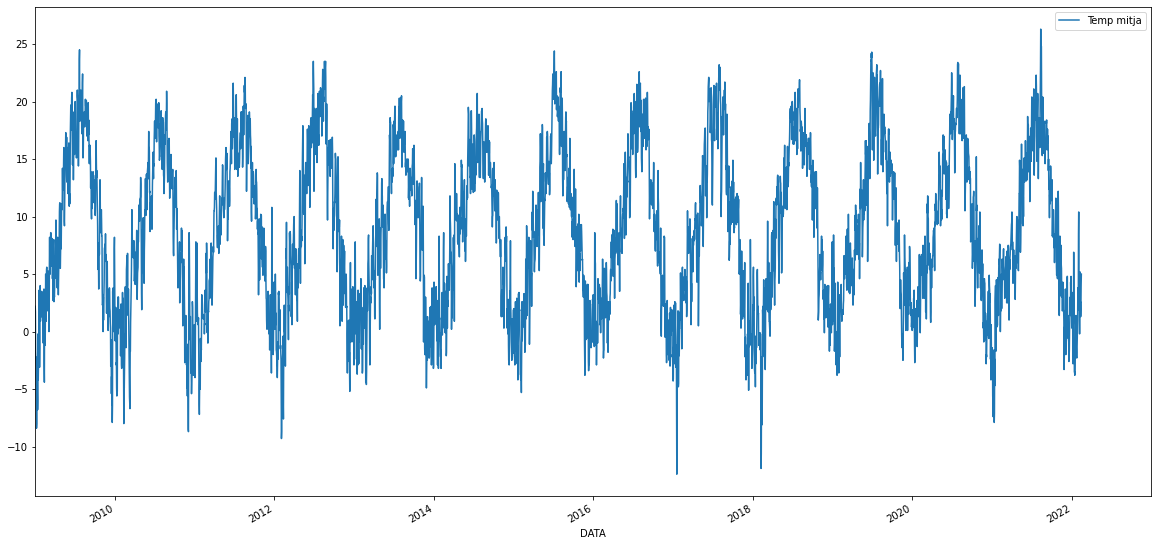

In [41]:
# Visualizamos gráfica de temperatura:
dfC.plot(kind='line',x='DATA',y='Temp mitja',figsize=(20,10))
plt.xlim('2009-01-01', '2022-12-31')

(14245.0, 15339.0)

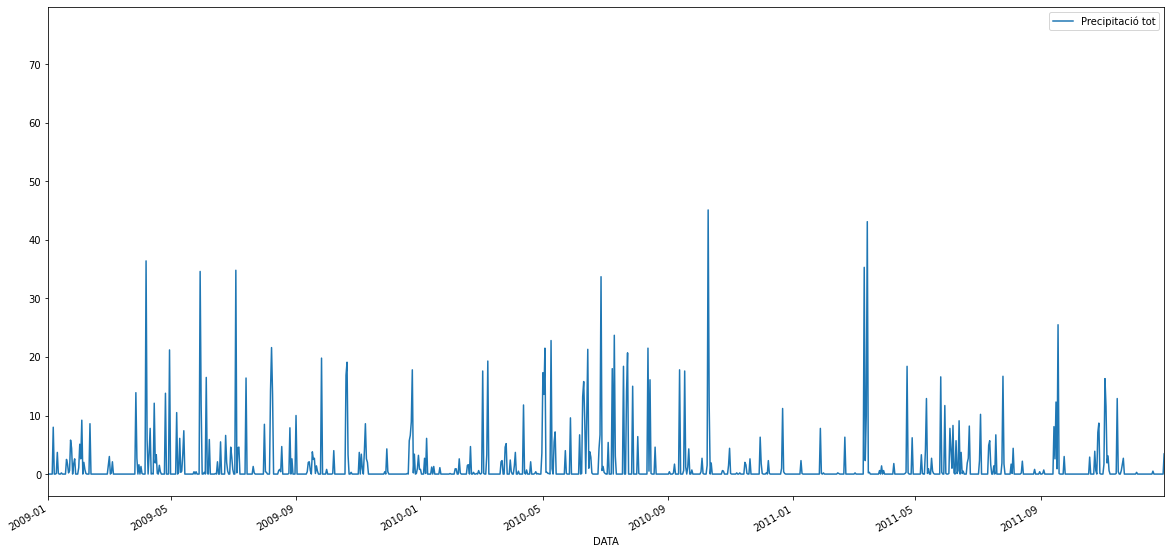

In [42]:
# Visualizamos gráfica de precipitación:
dfC.plot(kind='line',x='DATA',y='Precipitació tot',figsize=(20,10))
plt.xlim('2009-01-01', '2011-12-31')

In [43]:
# Vemos la correlación entre la diferencia de presiones y la precipitación al dia siguiente:
from scipy import stats

pearson_coef, p_value=stats.pearsonr(dfC['Dif.Pressió'],dfC['Precipitació demà'])
print('Pearson_coef:',pearson_coef)
print('p_value:',p_value)

Pearson_coef: 0.0233666279821021
p_value: 0.10587851023539344


In [44]:
# Vemos la correlación entre la diferencia de temperaturas y la precipitación:
pearson_coef, p_value=stats.pearsonr(dfC['Dif.Temp'],dfC['Precipitació tot'])
print('Pearson_coef:',pearson_coef)
print('p_value:',p_value)

Pearson_coef: -0.2896359590701026
p_value: 3.182455244229656e-93
